In [68]:
from abc import abstractmethod, ABC
from typing import Callable, Tuple, List, Optional, NoReturn
from IPython.core.display_functions import display
from sklearn.datasets import make_classification, make_moons
from sklearn import datasets
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score, f1_score, balanced_accuracy_score
from time import time_ns, time
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
plt.rcParams["figure.figsize"] = (20,10)
random_state = 244827
n_samples = 2427
n_trains = 1

In [69]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float]:
                continue

            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1
        return self

    def transpose_data(self):
        self.x_train = self.x_train.T
        self.x_test = self.x_test.T
        # self.y_test = self.y_test.reshape(1, -1)
        # self.y_train = self.y_train.reshape(1, -1)
        return self

    def change_labels(self, old: list, new: list):
        for o, n in zip(old, new):
            self.y_test[self.y_test == o] = n
            self.y_train[self.y_train == o] = n
        return self

    def winsorize(self):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float] or len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)
        return self

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)
        return self

In [70]:
class ActivationFunction(ABC):
    threshold = 0.5

    @abstractmethod
    def __call__(self, x: ndarray) -> ndarray:
        raise NotImplementedError

    @abstractmethod
    def derivative(self, x: ndarray) -> ndarray:
        raise NotImplementedError

    def d(self, x: ndarray) -> ndarray:
        return self.derivative(x)

class Heaviside(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return np.where(x >= 0, 1, 0)

    def derivative(self, x: ndarray) -> ndarray:
        return np.ones_like(x)

class Sin(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return (np.sin(x)+1)/2

    def derivative(self, x: ndarray) -> ndarray:
        return np.cos(x)

class Tanh(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return (np.tanh(x)+1)/2

    def derivative(self, x: ndarray) -> ndarray:
        return 1 / (np.cosh(x) ** 2)

class Sign(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return (np.sign(x) + 1)/2

    def derivative(self, x: ndarray) -> ndarray:
        return np.ones_like(x)

class Relu(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return np.where(x > 0, x, 0)

    def derivative(self, x: ndarray) -> ndarray:
        return np.where(x > 0, 1, 0)

class LeakyRelu(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return np.where(x >= 0, x, 0.01 * x)

    def derivative(self, x: ndarray) -> ndarray:
        return np.where(x >= 0, 1, 0.01)

class Sigmoid(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: ndarray) -> ndarray:
        return self(x) * (1 - self(x))

class Softmax(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def derivative(self, x: ndarray) -> ndarray:
        return self(x) * (1 - self(x))

In [94]:
class LayerInterface(ABC):

    @abstractmethod
    def forward(self, X: ndarray) -> ndarray:
        raise NotImplementedError

    @abstractmethod
    def backward(self, grad: ndarray) ->ndarray:
        raise NotImplementedError

    @abstractmethod
    def adjust(self, learning_rate) -> NoReturn:
        raise NotImplementedError


class ActivationLayer(LayerInterface):
    _accepted_activation_functions = ['Heaviside', 'sin', 'tanh', 'sign', 'Relu', 'LeakyRelu', 'sigmoid', 'softmax']

    def __init__(self, activation: str):
        if activation not in self._accepted_activation_functions:
            raise ValueError(f'Activation function {activation} is not supported')

        self.activation = {'Heaviside': Heaviside(),
                           'sin': Sin(),
                           'tanh': Tanh(),
                           'sign': Sign(),
                           'Relu': Relu(),
                           'LeakyRelu': LeakyRelu(),
                           'sigmoid': Sigmoid(),
                           'softmax': Softmax()}[activation]

        self.S_cache = None

    def forward(self, X: ndarray) -> ndarray:
        self.S_cache = X.copy()
        return self.activation(X)

    def backward(self, grad: ndarray) -> ndarray:
        return np.multiply(grad, self.activation.d(self.S_cache))

    def adjust(self, learning_rate) -> NoReturn:
        pass


class DenseLayer(LayerInterface):
    def __init__(self, input_features, n_units):
        self.coefs_: ndarray = np.random.normal(loc=1, scale=.15, size=(n_units, input_features))
        self.intercepts: ndarray = np.random.normal(loc=1, scale=.15, size=(n_units, 1))
        self.X_cache: Optional[ndarray] = None
        self.grad_cache: Optional[ndarray] = None

    def forward(self, X: ndarray) -> ndarray:
        self.X_cache = X
        return np.dot(self.coefs_, X) + self.intercepts

    def backward(self, grad: ndarray) -> ndarray:
        self.grad_cache = grad
        return np.dot(self.coefs_.T, grad)

    def adjust(self, learning_rate) -> NoReturn:
        self.coefs_ -= learning_rate * np.dot(self.grad_cache, self.X_cache.T)
        self.intercepts -= learning_rate * np.sum(self.grad_cache, axis=1, keepdims=True)


class NeuralNetwork:
    def __init__(self, layers: List[LayerInterface]):
        self.layers: List[LayerInterface] = layers

    def forward(self, X: ndarray) -> ndarray:
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, grad: ndarray) -> ndarray:
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def fit(self, x_train, y_train, learning_rate=0.1, max_learning_rate=0.1, min_learning_rate=0.001, epochs=1000, batch_size=32 ,verbose=False, dynamic_lr=True):
        n = x_train.shape[1]
        batch_divisible = n - n % batch_size

        for _ in tqdm(range(epochs), disable=not verbose):
            indexes = np.arange(0, n, 1)
            np.random.shuffle(indexes)
            batched_X = x_train.T
            batched_X = batched_X[indexes]
            batched_Y = y_train[indexes]

            batched_X = batched_X[:batch_divisible]
            batched_Y = batched_Y[:batch_divisible]

            for i in range(0, batch_divisible, batch_size):
                X_batch = batched_X[i:i+batch_size]
                Y_batch = batched_Y[i:i+batch_size]

                if len(X_batch.shape) == 1:
                    X_batch = X_batch.reshape(1, -1)

                X_batch = X_batch.T
                preds = self.forward(X_batch)
                Y_batch = Y_batch.reshape(preds.shape)
                E = preds - Y_batch
                # E = -(np.divide(Y_batch, preds) * np.divide(1 - Y_batch, 1 - preds))
                self.backward(E)
                for layer in self.layers:
                    layer.adjust(learning_rate)

                if dynamic_lr:
                    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * (1 + np.cos(np.e / epochs * np.pi))

    def decision_function(self, x_test):
        return self.forward(x_test)

    def predict(self, x_test):
        functions = self.forward(x_test)
        if functions.shape[0] == 1:
            return np.where(functions >= 0.5, 1, 0)
        # preds = np.zeros

In [95]:
def display_neural_network(model: NeuralNetwork, data: PUMData):
    f, ax = plt.subplots(1, 3, tight_layout=True, figsize=(20, 10))

    x_min, x_max = data.x_test[0, :].min() - 0.25, data.x_test[0, :].max() + 0.25
    y_min, y_max = data.x_test[1, :].min() - 0.25, data.x_test[1, :].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_data.T).reshape(xx.shape)

    ax[0].contourf(xx, yy, Z, alpha=0.4, levels=1)
    ax[0].scatter(data.x_test[0, :], data.x_test[1, :], c=data.y_test, s=20, edgecolor="k")
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)

    predictions = model.predict(data.x_test).reshape(data.y_test.shape)
    cm = confusion_matrix(data.y_test, predictions, labels=[0, 1])
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specifity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    sns.heatmap(cm, annot=True, fmt="d", ax=ax[1], cmap="Blues")
    ax[1].set_title(
        f'Czulość: {sensitivity}, swoistość: {specifity}, Adjusted accuracy={balanced_accuracy_score(data.y_test, predictions, adjusted=True)}')

    decision_function = model.decision_function(data.x_test).reshape(data.y_test.shape)
    fpr, tpr, thresholds = roc_curve(data.y_test, decision_function)
    ax[2].plot(fpr, tpr, label=f'Model AUC={roc_auc_score(data.y_test, decision_function):.3f}')
    ax[2].plot([0, 1], [0, 1], 'k--')
    ax[2].set_xlabel('FPR')
    ax[2].set_ylabel('TPR')
    ax[2].set_title('ROC')
    ax[2].legend()
    plt.show()

    # return balanced_accuracy_score(data.y_test, predictions, adjusted=True)
    return decision_function

In [96]:
linear_data = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2, random_state=random_state), random_state=random_state).transpose_data()
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)).transpose_data()

In [97]:
model = NeuralNetwork([
    DenseLayer(2, 4),
    ActivationLayer('sigmoid'),
    DenseLayer(4, 4),
    ActivationLayer('sigmoid'),
    DenseLayer(4, 1),
    ActivationLayer('sigmoid'),
])

In [98]:
model.fit(linear_data.x_train, linear_data.y_train, epochs=1000, verbose=True, learning_rate=0.1, batch_size=32)

100%|██████████| 1000/1000 [00:07<00:00, 141.32it/s]


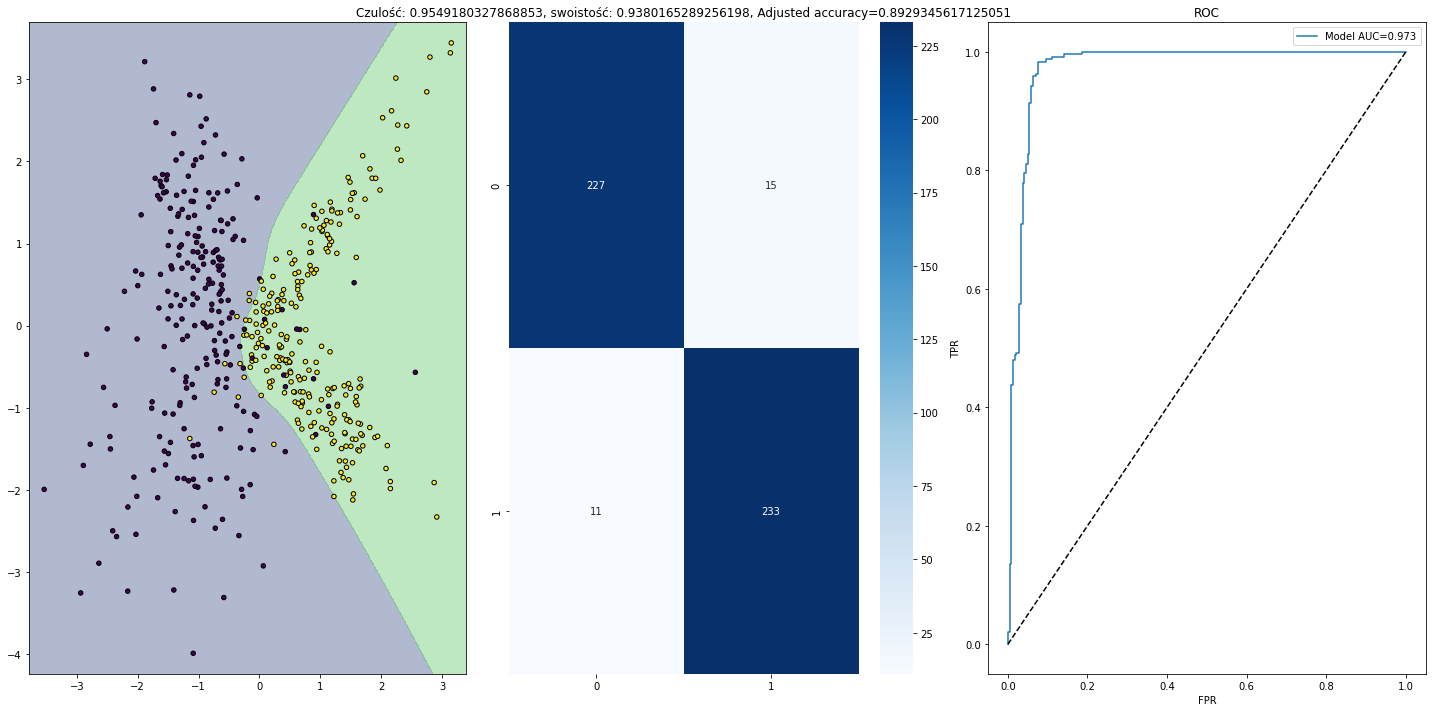

In [99]:
temp = display_neural_network(model, linear_data)

In [100]:
model_moons = NeuralNetwork([
    DenseLayer(2, 4),
    ActivationLayer('sigmoid'),
    DenseLayer(4, 8),
    ActivationLayer('sigmoid'),
    DenseLayer(8, 1),
    ActivationLayer('sigmoid'),
])
model_moons.fit(data_moons.x_train, data_moons.y_train, epochs=1000, verbose=True, learning_rate=0.01, batch_size=64)

100%|██████████| 1000/1000 [00:04<00:00, 245.56it/s]


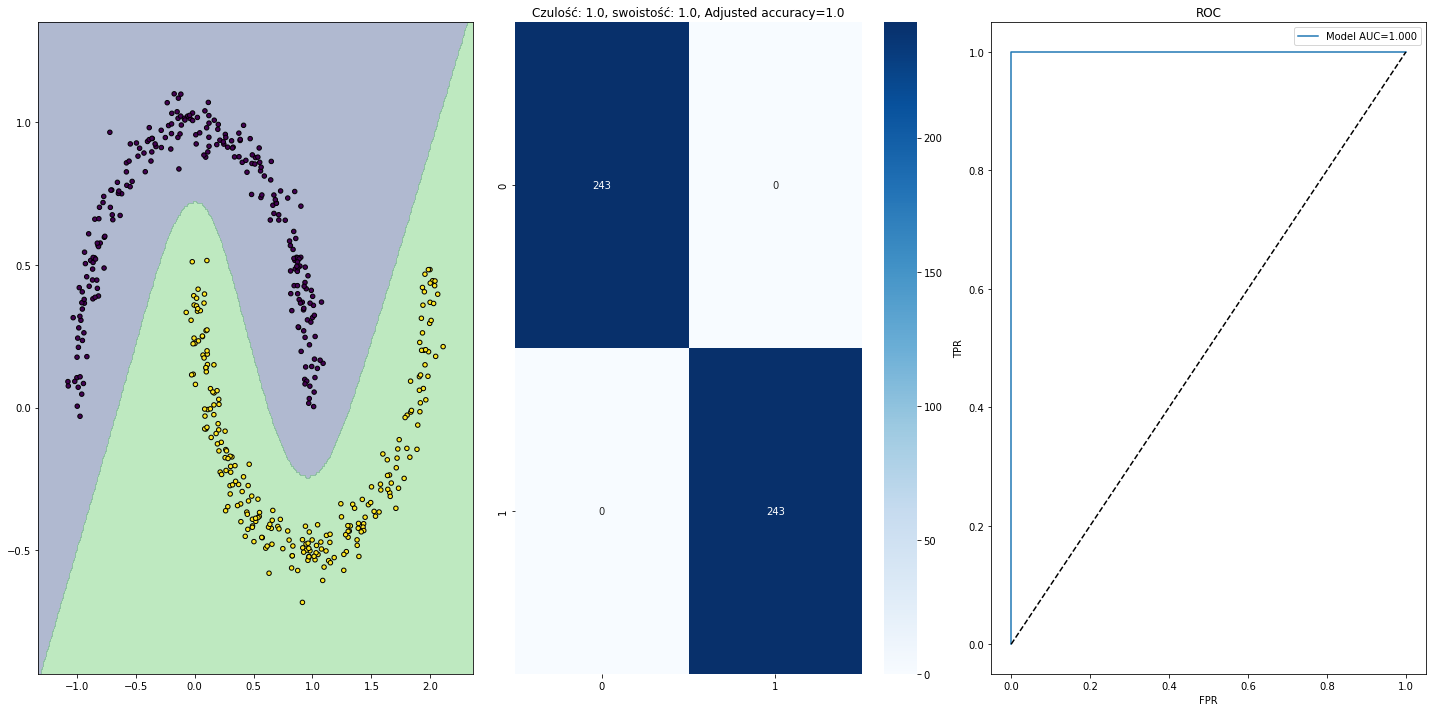

In [101]:
_ = display_neural_network(model_moons, data_moons)

In [102]:
from mnistdb.io import load

MNIST = load(one_hot=True)

In [ ]:
MNISTData = PUMData(make_classification())
MNISTData.x_train = MNIST.trainX
MNISTData.y_train = MNIST.trainY
MNISTData.x_test = MNIST.testX
MNISTData.y_test = MNIST.testY
MNISTData.transpose_data()

In [ ]:
test = NeuralNetwork([
    DenseLayer(784, 4),
    ActivationLayer('sigmoid'),
    DenseLayer(4, 8),
    ActivationLayer('sigmoid'),
    DenseLayer(8, 10),
    ActivationLayer('softmax'),
])

In [ ]:
test.fit(x_train=MNISTData.x_train, y_train=MNISTData.y_train, epochs=1000, batch_size=128, verbose=True)

In [ ]:
function = test.decision_function(MNISTData.x_test)

In [ ]:
function[2, 0] = 1

In [ ]:
print(np.argmax(function, axis=0, keepdims=True))

In [ ]:
preds = np.zeros_like(function)

In [ ]:
print(preds[:, :5])

In [ ]:
# preds[np.argmax(function, axis=0, keepdims=True)] = 1

In [ ]:
print(preds[:, :5])